<a href="https://colab.research.google.com/github/AbhishekChamarajanagar/Abhi/blob/master/diabetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle


In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karunyaraj","key":"1402ea2922c4fca92ff95411a063b924"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download dataset
!kaggle competitions download -c aptos2019-blindness-detection

# Unzip dataset
!unzip aptos2019-blindness-detection.zip -d aptos2019_data


Streaming output truncated to the last 5000 lines.
  inflating: aptos2019_data/test_images/512beaada8f0.png  
  inflating: aptos2019_data/test_images/51323e9d2070.png  
  inflating: aptos2019_data/test_images/515675001b9e.png  
  inflating: aptos2019_data/test_images/515877da2def.png  
  inflating: aptos2019_data/test_images/5168ddccea88.png  
  inflating: aptos2019_data/test_images/5172c056a687.png  
  inflating: aptos2019_data/test_images/5177461f5339.png  
  inflating: aptos2019_data/test_images/51910bcb980d.png  
  inflating: aptos2019_data/test_images/51a3e9b6a1c0.png  
  inflating: aptos2019_data/test_images/51bbd82feec8.png  
  inflating: aptos2019_data/test_images/51de5fb8eccd.png  
  inflating: aptos2019_data/test_images/51e88694c81f.png  
  inflating: aptos2019_data/test_images/51f0bf8f1544.png  
  inflating: aptos2019_data/test_images/51f57fb32840.png  
  inflating: aptos2019_data/test_images/51fa42dc1415.png  
  inflating: aptos2019_data/test_images/5276ab33b7b0.png  
  inf

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torchvision.io import read_image
import cv2
import seaborn as sns
from tqdm import tqdm
print(torch.__version__)

2.5.1+cu124


In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available. Device name: Tesla T4


In [ ]:
train = pd.read_csv('/content/aptos2019_data/train.csv')
test = pd.read_csv('/content/aptos2019_data/test.csv')

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
import matplotlib.pyplot as plt


<ipython-input-10-5a39dd9eea6e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")


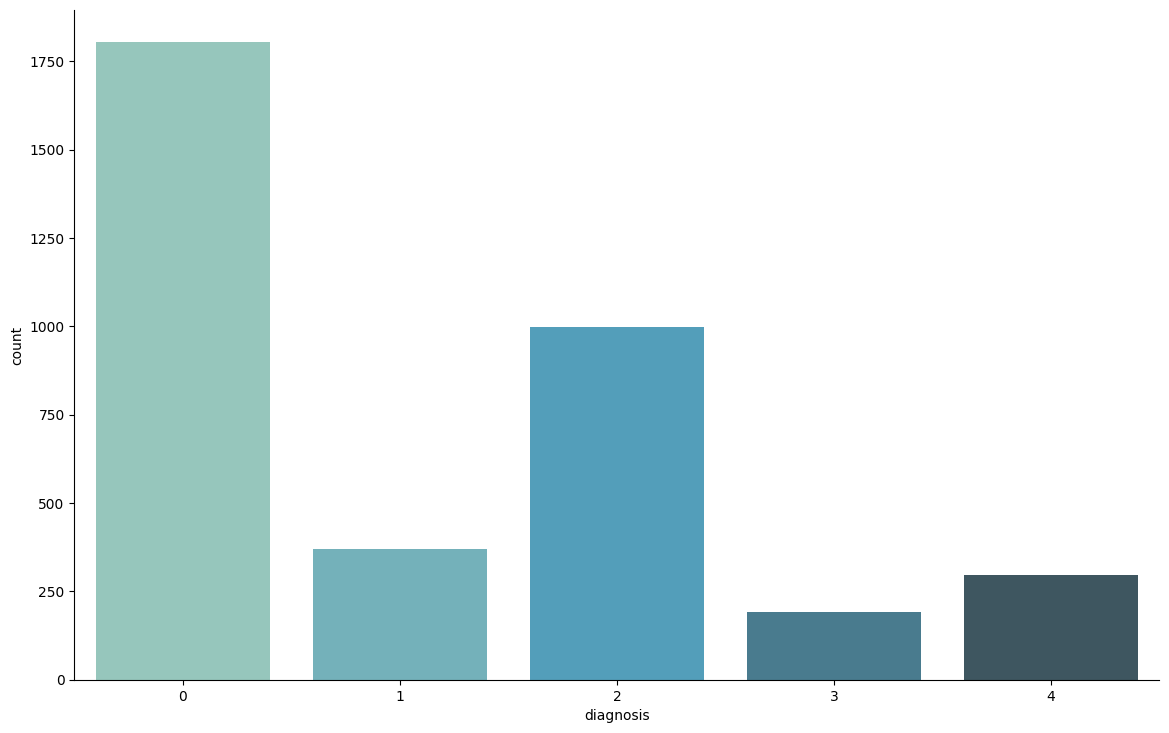

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

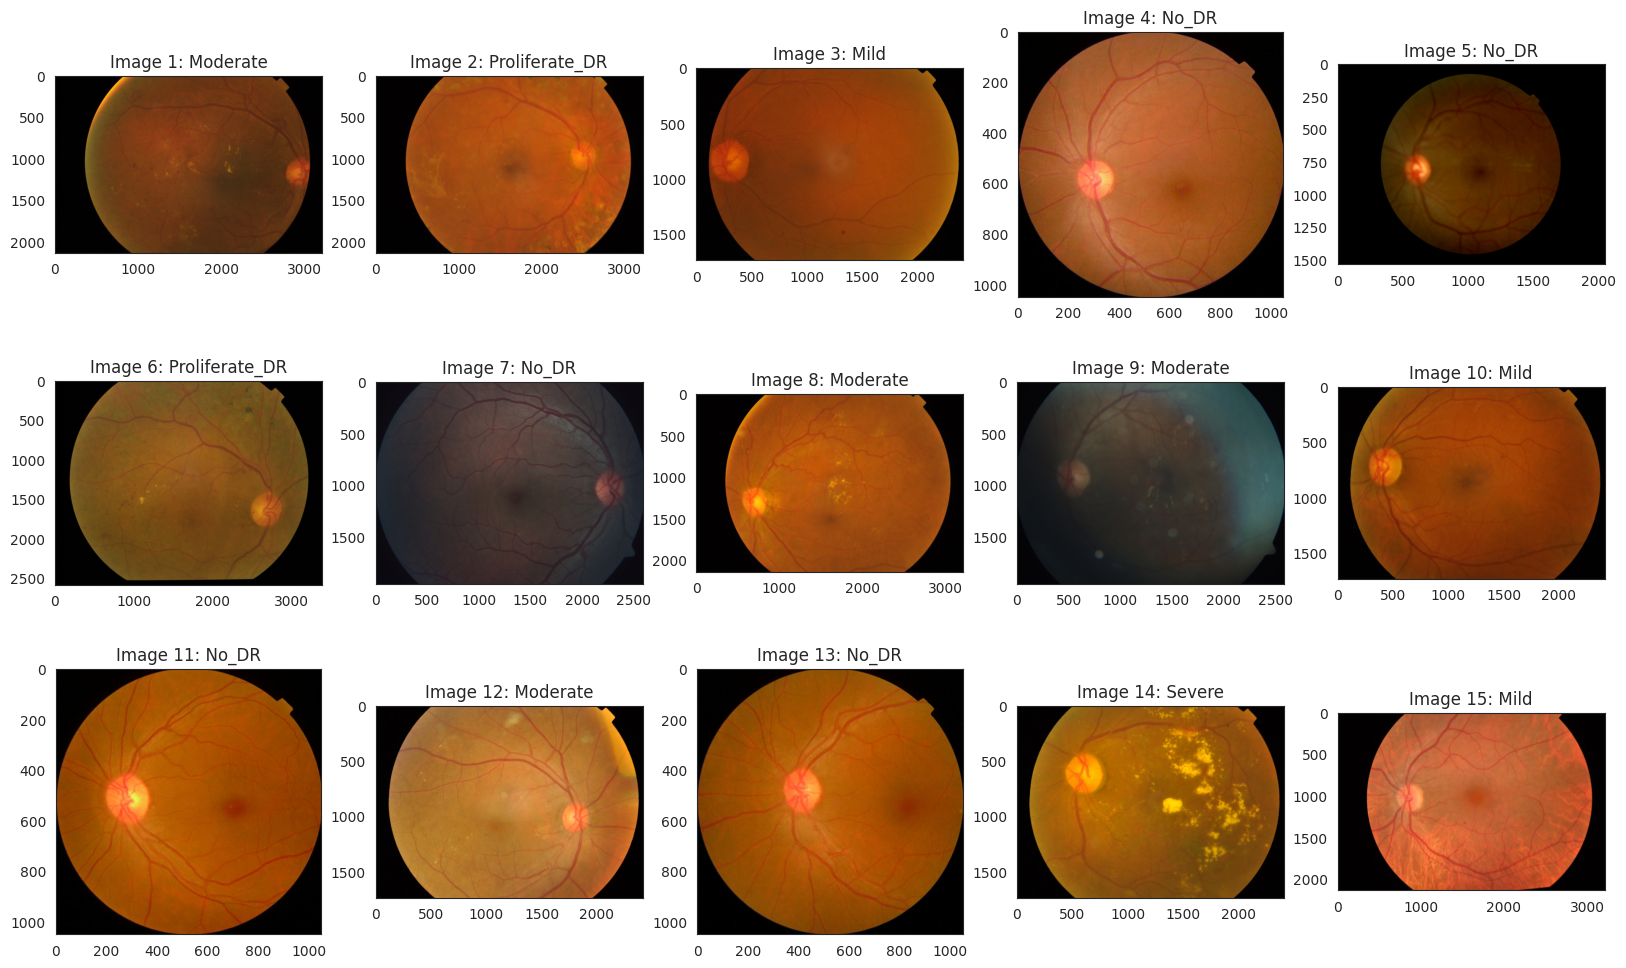

In [ ]:
# Setting the style for the plot
sns.set_style("white")

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:  # Assuming 'train' contains the dataset
    img = cv2.imread(f"/content/aptos2019_data/train_images/{img_name}.png")[..., [2, 1, 0]]  # Reading the image

    # Getting the label (class) for the image
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]  # Assuming 'diagnosis' is the label column

    # Setting up the subplot with image and label
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1

# Display the plot
plt.show()


In [ ]:
DATA_DIR = "/content/aptos2019_data"
TRAIN_DIR = "/content/aptos2019_data/train_images"
CSV_PATH = "/content/aptos2019_data/train.csv"
MODEL_PATH = "/content/aptos2019_data"
TRAIN_SPLIT = 0.8
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
NUM_WORKERS = 2
USE_AMP = True


In [ ]:
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join('../input/aptos2019-blindness-detection/train_images',
        #                         self.data.loc[idx, 'id_code'] + '.png')

        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [ ]:
@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:k].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]


def set_debug_apis(state: bool = False):
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)


def seed_everything(seed):
    """
    Makes code deterministic using a given seed.
    Internally sets all seeds of torch, numpy and random.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print("Size (MB):", os.path.getsize("temp.p") / 1e6)
    os.remove("temp.p")


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
def train_step(model: nn.Module, train_loader, criterion,
               device: str, optimizer,
               scheduler=None, num_batches: int = None,
               log_interval: int = 100,
               scaler=None,):
    """
    Performs one step of training. Calculates loss, forward pass, computes gradient and returns metrics.
    Args:
        model : A pytorch CNN Model.
        train_loader : Train loader.
        criterion : Loss function to be optimized.
        device : "cuda" or "cpu"
        optimizer : Torch optimizer to train.
        scheduler : Learning rate scheduler.
        num_batches : (optional) Integer To limit training to certain number of batches.
        log_interval : (optional) Defualt 100. Integer to Log after specified batch ids in every batch.
        scaler: (optional)  Pass tor


        ch.cuda.amp.GradScaler() for fp16 precision Training.
    """

    model = model.to(device)
    start_train_step = time.time()
    metrics = OrderedDict()
    model.train()
    last_idx = len(train_loader) - 1
    batch_time_m = AverageMeter()
    # data_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()
    cnt = 0
    batch_start = time.time()
    # num_updates = epoch * len(loader)

    for batch_idx, (inputs, target) in enumerate(train_loader):
        last_batch = batch_idx == last_idx
        # data_time_m.update(time.time() - batch_start)
        inputs = inputs.to(device)
        target = target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        if scaler is not None:
            with amp.autocast():
                output = model(inputs)
                loss = criterion(output, target)
                # Scale the loss using Grad Scaler
            scaler.scale(loss).backward()
            # Step using scaler.step()
            scaler.step(optimizer)
            # Update for next iteration
            scaler.update()

        else:
            output = model(inputs)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        cnt += 1
        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        top1_m.update(acc1.item(), output.size(0))
        top5_m.update(acc5.item(), output.size(0))
        losses_m.update(loss.item(), inputs.size(0))

        batch_time_m.update(time.time() - batch_start)
        batch_start = time.time()
        if last_batch or batch_idx % log_interval == 0:  # If we reach the log intervel
            print(
                "Batch Train Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  "
                "Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  "
                "Top 1 Accuracy: {top1.val:>7.4f} ({top1.avg:>7.4f})  "
                "Top 5 Accuracy: {top5.val:>7.4f} ({top5.avg:>7.4f})".format(
                    batch_time=batch_time_m, loss=losses_m, top1=top1_m, top5=top5_m))

        if num_batches is not None:
            if cnt >= num_batches:
                end_train_step = time.time()
                metrics["loss"] = losses_m.avg
                metrics["top1"] = top1_m.avg
                metrics["top5"] = top5_m.avg
                print(f"Done till {num_batches} train batches")
                print(f"Time taken for train step = {end_train_step - start_train_step} sec")
                return metrics

    metrics["loss"] = losses_m.avg
    metrics["top1"] = top1_m.avg
    metrics["top5"] = top5_m.avg
    end_train_step = time.time()
    print(f"Time taken for train step = {end_train_step - start_train_step} sec")
    return metrics

In [ ]:
@torch.no_grad()
def val_step(model: nn.Module, val_loader, criterion,
             device: str, num_batches=None,
             log_interval: int = 100):

    """
    Performs one step of validation. Calculates loss, forward pass and returns metrics.
    Args:
        model : A pytorch CNN Model.
        val_loader : Validation loader.
        criterion : Loss function to be optimized.
        device : "cuda" or "cpu"
        num_batches : (optional) Integer To limit validation to certain number of batches.
        log_interval : (optional) Defualt 100. Integer to Log after specified batch ids in every batch.
    """

    model = model.to(device)
    start_val_step = time.time()
    last_idx = len(val_loader) - 1
    batch_time_m = AverageMeter()
    # data_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()
    cnt = 0
    model.eval()
    batch_start = time.time()
    metrics = OrderedDict()

    for batch_idx, (inputs, target) in enumerate(val_loader):
        last_batch = batch_idx == last_idx
        inputs = inputs.to(device)
        target = target.to(device)

        output = model(inputs)
        loss = criterion(output, target)
        cnt += 1
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        reduced_loss = loss.data

        losses_m.update(reduced_loss.item(), inputs.size(0))
        top1_m.update(acc1.item(), output.size(0))
        top5_m.update(acc5.item(), output.size(0))
        batch_time_m.update(time.time() - batch_start)

        batch_start = time.time()

        if (last_batch or batch_idx % log_interval == 0):  # If we reach the log intervel
            print(
                "Batch Inference Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  "
                "Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  "
                "Top 1 Accuracy: {top1.val:>7.4f} ({top1.avg:>7.4f})  "
                "Top 5 Accuracy: {top5.val:>7.4f} ({top5.avg:>7.4f})".format(
                    batch_time=batch_time_m, loss=losses_m, top1=top1_m, top5=top5_m))

        if num_batches is not None:
            if cnt >= num_batches:
                end_val_step = time.time()
                metrics["loss"] = losses_m.avg
                metrics["top1"] = top1_m.avg
                metrics["top5"] = top5_m.avg
                print(f"Done till {num_batches} validation batches")
                print(f"Time taken for validation step = {end_val_step - start_val_step} sec")
                return metrics

    metrics["loss"] = losses_m.avg
    metrics["top1"] = top1_m.avg
    metrics["top5"] = top5_m.avg
    print("Finished the validation epoch")

    end_val_step = time.time()
    print(f"Time taken for validation step = {end_val_step - start_val_step} sec")
    return metrics

In [ ]:
EPOCHS = 10
IMG_WIDTH= 224
IMG_HEIGHT = 224
MODEL_NAME= "resnetv2_50"
MODEL_SAVE = "/content/aptos2019_data"

In [ ]:
seed_everything(42)
set_debug_apis(False)

train_trasforms_ResNetV2_50 = T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Resize((IMG_WIDTH, IMG_HEIGHT)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms_ResNetV2_50)

train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

In [ ]:
model= timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

if USE_AMP:
    from torch.cuda import amp
    scaler = amp.GradScaler()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

<ipython-input-20-7ad852a75cd5>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [ ]:
import pandas as pd
import time
from tqdm import tqdm

# Initialize lists to store metrics
train_loss = []
train_top1_acc = []
val_loss = []
val_top1_acc = []

# Record start time
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
    train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
    train_loss.append(train_metrics["loss"])
    print(f"Training loss = {train_metrics['loss']}")
    train_top1_acc.append(train_metrics["top1"])

    val_metrics = val_step(model,val_loader, criterion, device)
    val_loss.append(val_metrics["loss"])
    print(f"Validation loss = {val_metrics['loss']}")
    val_top1_acc.append(val_metrics["top1"])

    # Save model checkpoint
    checkpoint_path = f"{MODEL_NAME}_{epoch}.pt"
    torch.save(model.state_dict(), checkpoint_path)

# Record end time
end_time = time.time()

# Calculate total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    "epoch": range(1, EPOCHS + 1),
    "train_loss": train_loss,
    "train_top1_acc": train_top1_acc,
    "val_loss": val_loss,
    "val_top1_acc": val_top1_acc,
})


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-16-9688d3b6f588>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Batch Train Time: 15.526 (15.526)  Loss:  1.6116 (1.6116)  Top 1 Accuracy: 25.0000 (25.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.164 (4.161)  Loss:  0.9979 (1.2967)  Top 1 Accuracy: 65.6250 (59.2512)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.951 (4.118)  Loss:  0.9395 (1.2563)  Top 1 Accuracy: 53.1250 (59.5943)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 469.5485532283783 sec
Training loss = 1.2563107306497139
Batch Inference Time: 11.943 (11.943)  Loss:  1.0242 (1.0242)  Top 1 Accuracy: 59.3750 (59.3750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 4.950 (4.310)  Loss:  0.8938 (0.9814)  Top 1 Accuracy: 62.5000 (58.6648)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 94.89081597328186 sec
Validation loss = 0.9814482249996879


 10%|█         | 1/10 [09:24<1:24:44, 564.94s/it]

Batch Train Time: 9.863 (9.863)  Loss:  0.9235 (0.9235)  Top 1 Accuracy: 65.6250 (65.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.138 (4.173)  Loss:  0.8039 (0.9032)  Top 1 Accuracy: 75.0000 (67.2339)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.171 (4.139)  Loss:  0.8091 (0.8904)  Top 1 Accuracy: 65.6250 (67.9276)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 471.9196934700012 sec
Training loss = 0.8903945151128267
Batch Inference Time: 9.774 (9.774)  Loss:  0.8964 (0.8964)  Top 1 Accuracy: 68.7500 (68.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 4.962 (4.247)  Loss:  0.7629 (0.8067)  Top 1 Accuracy: 65.6250 (73.1534)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 93.49895358085632 sec
Validation loss = 0.8067194196310911


 20%|██        | 2/10 [18:50<1:15:22, 565.32s/it]

Batch Train Time: 9.357 (9.357)  Loss:  0.7251 (0.7251)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.160 (4.184)  Loss:  0.6522 (0.7547)  Top 1 Accuracy: 75.0000 (72.7723)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.873 (4.129)  Loss:  0.7504 (0.7443)  Top 1 Accuracy: 65.6250 (73.0537)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 470.74474024772644 sec
Training loss = 0.7443085302386367
Batch Inference Time: 10.405 (10.405)  Loss:  0.8908 (0.8908)  Top 1 Accuracy: 71.8750 (71.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 4.849 (4.281)  Loss:  0.7230 (0.7341)  Top 1 Accuracy: 68.7500 (74.1477)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 94.28408360481262 sec
Validation loss = 0.7341485145417127


 30%|███       | 3/10 [28:15<1:05:57, 565.29s/it]

Batch Train Time: 8.412 (8.412)  Loss:  0.5995 (0.5995)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.190 (4.101)  Loss:  0.5417 (0.6348)  Top 1 Accuracy: 75.0000 (74.3502)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.820 (4.071)  Loss:  0.7081 (0.6261)  Top 1 Accuracy: 65.6250 (74.5340)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 464.11307644844055 sec
Training loss = 0.6261077936281237
Batch Inference Time: 10.099 (10.099)  Loss:  0.8218 (0.8218)  Top 1 Accuracy: 68.7500 (68.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 5.132 (4.188)  Loss:  0.6759 (0.6510)  Top 1 Accuracy: 68.7500 (74.1477)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 92.24471783638 sec
Validation loss = 0.6509712744842876


 40%|████      | 4/10 [37:32<56:11, 561.86s/it]  

Batch Train Time: 8.147 (8.147)  Loss:  0.4716 (0.4716)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.937 (4.144)  Loss:  0.5041 (0.5320)  Top 1 Accuracy: 78.1250 (75.1238)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.038 (4.129)  Loss:  0.5700 (0.5260)  Top 1 Accuracy: 65.6250 (75.2741)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 470.8238379955292 sec
Training loss = 0.5259805204052674
Batch Inference Time: 8.164 (8.164)  Loss:  0.9012 (0.9012)  Top 1 Accuracy: 68.7500 (68.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 4.396 (4.127)  Loss:  0.8139 (0.6918)  Top 1 Accuracy: 68.7500 (74.5739)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 90.8717143535614 sec
Validation loss = 0.6918185407465155


 50%|█████     | 5/10 [46:54<46:49, 561.86s/it]

Batch Train Time: 10.249 (10.249)  Loss:  0.3831 (0.3831)  Top 1 Accuracy: 81.2500 (81.2500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.142 (4.214)  Loss:  0.4539 (0.4604)  Top 1 Accuracy: 78.1250 (77.9394)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 5.077 (4.177)  Loss:  0.5507 (0.4579)  Top 1 Accuracy: 68.7500 (78.0154)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 476.20682072639465 sec
Training loss = 0.4578722263114494
Batch Inference Time: 8.314 (8.314)  Loss:  0.7093 (0.7093)  Top 1 Accuracy: 71.8750 (71.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 4.529 (4.082)  Loss:  0.4746 (0.5043)  Top 1 Accuracy: 75.0000 (78.6932)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 89.86563539505005 sec
Validation loss = 0.5043307820504362


 60%|██████    | 6/10 [56:20<37:33, 563.34s/it]

Batch Train Time: 8.918 (8.918)  Loss:  0.2974 (0.2974)  Top 1 Accuracy: 87.5000 (87.5000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.132 (4.184)  Loss:  0.3351 (0.3860)  Top 1 Accuracy: 87.5000 (83.1993)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.696 (4.132)  Loss:  0.3909 (0.3823)  Top 1 Accuracy: 81.2500 (83.1963)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 471.13675141334534 sec
Training loss = 0.3822702032170798
Batch Inference Time: 10.135 (10.135)  Loss:  0.6417 (0.6417)  Top 1 Accuracy: 68.7500 (68.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 5.177 (4.247)  Loss:  0.3801 (0.3991)  Top 1 Accuracy: 81.2500 (84.8011)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 93.51747798919678 sec
Validation loss = 0.3990795917131684


 70%|███████   | 7/10 [1:05:45<28:11, 563.85s/it]

Batch Train Time: 8.283 (8.283)  Loss:  0.2177 (0.2177)  Top 1 Accuracy: 90.6250 (90.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.145 (4.139)  Loss:  0.2990 (0.3190)  Top 1 Accuracy: 93.7500 (86.7884)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.996 (4.114)  Loss:  0.3154 (0.3185)  Top 1 Accuracy: 84.3750 (86.7599)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 469.02886867523193 sec
Training loss = 0.3185272288688442
Batch Inference Time: 8.113 (8.113)  Loss:  0.6287 (0.6287)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.804 (4.194)  Loss:  0.4272 (0.3719)  Top 1 Accuracy: 81.2500 (85.9375)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 92.32896995544434 sec
Validation loss = 0.37193771824240685


 80%|████████  | 8/10 [1:15:06<18:46, 563.12s/it]

Batch Train Time: 10.306 (10.306)  Loss:  0.1821 (0.1821)  Top 1 Accuracy: 93.7500 (93.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.153 (4.221)  Loss:  0.2600 (0.2737)  Top 1 Accuracy: 93.7500 (89.9134)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 5.107 (4.188)  Loss:  0.2646 (0.2737)  Top 1 Accuracy: 87.5000 (89.8849)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 477.52808117866516 sec
Training loss = 0.2736722727616628
Batch Inference Time: 8.190 (8.190)  Loss:  0.6817 (0.6817)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.538 (4.214)  Loss:  0.4025 (0.3403)  Top 1 Accuracy: 78.1250 (86.0795)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 92.7695255279541 sec
Validation loss = 0.3403219252147458


 90%|█████████ | 9/10 [1:24:37<09:25, 565.41s/it]

Batch Train Time: 10.614 (10.614)  Loss:  0.1534 (0.1534)  Top 1 Accuracy: 93.7500 (93.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.881 (4.142)  Loss:  0.2084 (0.2296)  Top 1 Accuracy: 96.8750 (91.3366)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.158 (4.099)  Loss:  0.2065 (0.2304)  Top 1 Accuracy: 90.6250 (91.2829)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 467.37138772010803 sec
Training loss = 0.23038645029852264
Batch Inference Time: 10.295 (10.295)  Loss:  0.4590 (0.4590)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 5.531 (4.286)  Loss:  0.3600 (0.3380)  Top 1 Accuracy: 84.3750 (86.6477)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 94.41439390182495 sec
Validation loss = 0.3380448879166083


100%|██████████| 10/10 [1:33:59<00:00, 563.93s/it]

Total training time: 5639.36 seconds


In [ ]:
MODEL_SAVE = "/content/aptos2019_data/metrics.csv"  # Ensure it's a file path

# Save the DataFrame to CSV
metrics_df.to_csv(MODEL_SAVE, index=False)
print(f"Metrics saved to {MODEL_SAVE}")


Metrics saved to /content/aptos2019_data/metrics.csv


Visualization saved to resnetv2_50_training_visualization.png


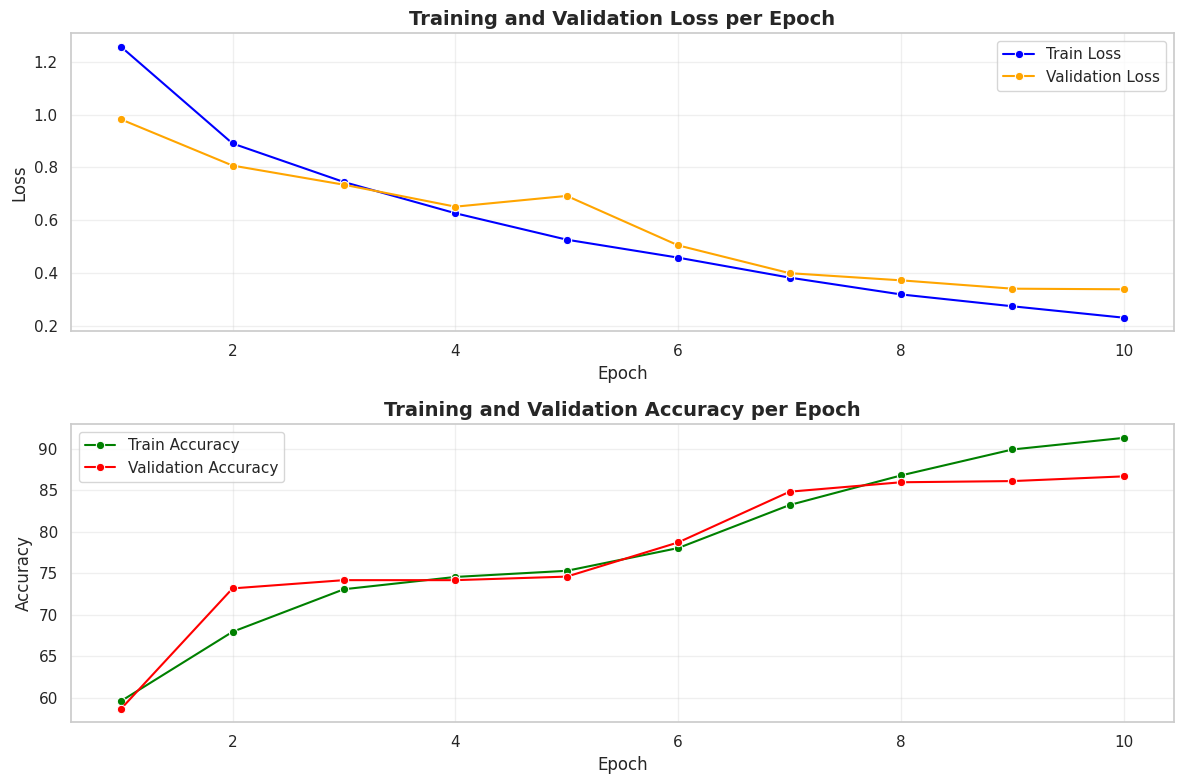

In [ ]:
metrics_path = f"{MODEL_NAME}_metrics.csv"  # Path to metrics CSV
metrics_df = pd.read_csv(MODEL_SAVE)

# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure for visualizations
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
sns.lineplot(x='epoch', y='train_loss', data=metrics_df, label='Train Loss', color='blue', marker="o")
sns.lineplot(x='epoch', y='val_loss', data=metrics_df, label='Validation Loss', color='orange', marker="o")
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
sns.lineplot(x='epoch', y='train_top1_acc', data=metrics_df, label='Train Accuracy', color='green', marker="o")
sns.lineplot(x='epoch', y='val_top1_acc', data=metrics_df, label='Validation Accuracy', color='red', marker="o")
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Adjust spacing between plots
plt.tight_layout()

# Save the visualization as a file (optional)
output_plot_path = f"{MODEL_NAME}_training_visualization.png"
plt.savefig(output_plot_path, dpi=300)
print(f"Visualization saved to {output_plot_path}")

# Show the plots
plt.show()

In [ ]:
# Load your model from checkpoint
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model


In [ ]:
# Predict on validation data
def predict_on_validation(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to compute gradients for validation
        for inputs, labels in val_loader:  # Assuming dataloader is a dictionary with 'val' key
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [ ]:
# Define paths and device
checkpoint_path = "/content/resnetv2_50_9.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_class=5
# Initialize and load the model (replace YourModel with your actual model class)
model = load_model_from_checkpoint(checkpoint_path, model_class, device)

# Assuming `dataloaders` is a dictionary with 'val' key containing the validation dataloader
# Predict on validation set
y_true, y_pred = predict_on_validation(model, val_loader, device)


<ipython-input-25-baa69874f734>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [ ]:
from sklearn.metrics import confusion_matrix


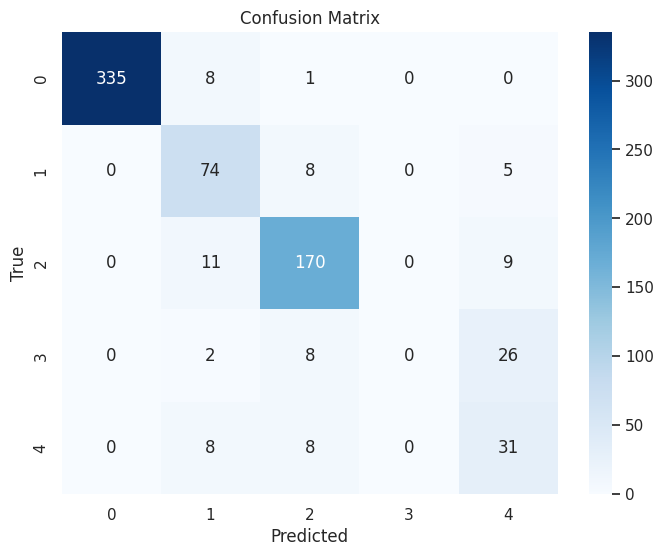

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

# Calculate errors per class (misclassifications)
class_errors = {}
num_classes = cm.shape[0]
for i in range(num_classes):
    total = np.sum(cm[i, :])  # Total number of instances of class i
    incorrect = total - cm[i, i]  # Misclassified instances of class i
    error_rate = incorrect / total if total != 0 else 0
    class_errors[i] = error_rate

# Print class errors
for class_id, error_rate in class_errors.items():
    print(f"Class {class_id}: Error Rate = {error_rate:.4f}")


Class 0: Error Rate = 0.0262
Class 1: Error Rate = 0.1494
Class 2: Error Rate = 0.1053
Class 3: Error Rate = 1.0000
Class 4: Error Rate = 0.3404


In [ ]:
# Create a DataFrame for the error rates
error_data = pd.DataFrame(list(class_errors.items()), columns=['Class', 'Error Rate'])


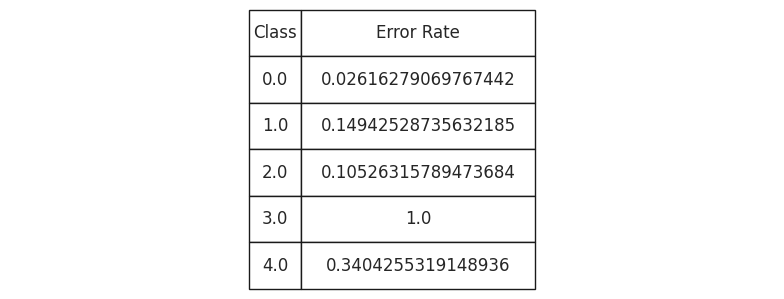

In [ ]:
# Plot only the table, fitting the entire figure
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('off')  # Turn off axis for the table

# Create and display the table, making it fill the figure
table = ax.table(cellText=error_data.values, colLabels=error_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(error_data.columns))))
table.scale(20, 5)  # Scale table size (adjust the values as needed)

plt.tight_layout()
plt.show()


In [ ]:
import torch

# Save the model
torch.save(model.state_dict(), 'resnetv2_50_9.pt')


In [ ]:
torch.save(model, 'resnetv2_50_9.pt')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save model to Google Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RuntimeError: File /content/drive/MyDrive/Colab Notebooks cannot be opened.

In [ ]:
import os
# Create a folder called 'models' in your Google Drive (if it doesn't exist)
os.makedirs('/content/drive/MyDrive/models', exist_ok=True)

# Now, save the model to that folder
torch.save(model.state_dict(), '/content/drive/MyDrive/models/resnetv2_50_9.pt')


In [ ]:
!df -h


Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   49G   64G  44% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G  4.0K  5.7G   1% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs           6.4G  256K  6.4G   1% /var/colab
/dev/sda1        92G   66G   26G  72% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   45M   15G   1% /content/drive


In [ ]:
checkpoint_path = f"/content/{MODEL_NAME}_{epoch}.pt"
torch.save(model.state_dict(), checkpoint_path)


In [ ]:
import os
print("Saved files:", os.listdir("/content/"))


Saved files: ['.config', 'drive', 'resnetv2_50_5.pt', 'aptos2019-blindness-detection.zip', 'resnetv2_50_6.pt', 'resnetv2_50_9.pt', 'resnetv2_50_training_visualization.png', 'resnetv2_50_8.pt', 'resnetv2_50_3.pt', 'resnetv2_50_4.pt', 'resnetv2_50_2.pt', 'resnetv2_50_1.pt', 'resnetv2_50_0.pt', 'resnetv2_50_7.pt', 'aptos2019_data', 'sample_data']
